In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv


In [3]:
df = pd.read_csv("/kaggle/input/american-companies-bankruptcy-prediction-dataset/american_bankruptcy.csv")
df.head()

,company_name,status_label,year,X1,X2,X3,X4,X5,X6,X7,...,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
0,C_1,alive,1999,511.267,833.107,18.373,89.031,336.018,35.163,128.348,...,1024.333,740.998,180.447,70.658,191.226,163.816,201.026,1024.333,401.483,935.302
1,C_1,alive,2000,485.856,713.811,18.577,64.367,320.590,18.531,115.187,...,874.255,701.854,179.987,45.790,160.444,125.392,204.065,874.255,361.642,809.888
2,C_1,alive,2001,436.656,526.477,22.496,27.207,286.588,-58.939,77.528,...,638.721,710.199,217.699,4.711,112.244,150.464,139.603,638.721,399.964,611.514
3,C_1,alive,2002,396.412,496.747,27.172,30.745,259.954,-12.410,66.322,...,606.337,686.621,164.658,3.573,109.590,203.575,124.106,606.337,391.633,575.592
4,C_1,alive,2003,432.204,523.302,26.680,47.491,247.245,3.504,104.661,...,651.958,709.292,248.666,20.811,128.656,131.261,131.884,651.958,407.608,604.467


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78682 entries, 0 to 78681
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_name  78682 non-null  object 
 1   status_label  78682 non-null  object 
 2   year          78682 non-null  int64  
 3   X1            78682 non-null  float64
 4   X2            78682 non-null  float64
 5   X3            78682 non-null  float64
 6   X4            78682 non-null  float64
 7   X5            78682 non-null  float64
 8   X6            78682 non-null  float64
 9   X7            78682 non-null  float64
 10  X8            78682 non-null  float64
 11  X9            78682 non-null  float64
 12  X10           78682 non-null  float64
 13  X11           78682 non-null  float64
 14  X12           78682 non-null  float64
 15  X13           78682 non-null  float64
 16  X14           78682 non-null  float64
 17  X15           78682 non-null  float64
 18  X16           78682 non-nu

/tmp/ipykernel_33/2249596087.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

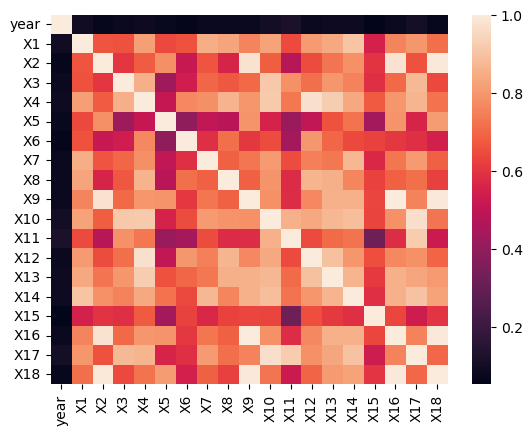

In [5]:
import seaborn as sns
sns.heatmap(df.corr())

In [7]:
df["status_label"].value_counts()

alive     73462
failed     5220
Name: status_label, dtype: int64

In [8]:
df.duplicated().any().sum()

0

**The classes are imbalanced and some features are highly corelated to each other, lets use PCA.**

In [9]:
from sklearn.preprocessing import LabelEncoder

X = df.drop(["company_name", "status_label"], axis=1)
y = df["status_label"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("Shape of X is:", X.shape)
print("Shape of y is:", y.shape)

Shape of X is: (78682, 19)
Shape of y is: (78682,)


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X = pca.fit_transform(X)

print("Shape of X is:", X.shape)
print("Shape of y is:", y.shape)

Shape of X is: (78682, 3)
Shape of y is: (78682,)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Since this is an imbalanced data classification task we can use SMOTE.**

In [14]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_train.shape, X_resampled.shape, y_train.shape, y_resampled.shape

((62945, 3), (117586, 3), (62945,), (117586,))

In [19]:
np.mean(y_train), np.mean(y_resampled)

(0.06596234808165859, 0.5)

**Now let's train Logistic Regression on X_train and X_resampled to see the difference in classification!**

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

def error_analysis(model_name, y_pred, y_pred_proba, y_test=y_test):
    
    conf_mtx = confusion_matrix(y_test, y_pred)
    clf_rep = classification_report(y_test, y_pred)
    auc_sc = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    print(f"Confusion Matrix of {model_name} is:\n", conf_mtx)
    print(f"Classification report of {model_name} is:\n", clf_rep)
    print(f"AUC Score of {model_name} is:\n", auc_sc)

def get_results(model, X_train, X_test, y_train, proba=True):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if proba:
        y_pred_proba = model.predict_proba(X_test)
        return y_pred_proba, y_pred
    return y_pred

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'max_iter': [100, 500, 1000, 2000]
}

log_reg_pipeline = make_pipeline(StandardScaler(), GridSearchCV(LogisticRegression(), param_grid))

y_pred_proba, y_pred = get_results(log_reg_pipeline, X_train, X_test, y_train, proba=True)
y_pred_proba_resampled, y_pred_resampled = get_results(log_reg_pipeline, X_resampled, X_test, y_resampled, proba=True)

In [34]:
error_analysis("Logistic Regression without Resampling", y_pred, y_pred_proba, y_test)

Confusion Matrix of Logistic Regression without Resampling is:
 [[14668     1]
 [ 1068     0]]
Classification report of Logistic Regression without Resampling is:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     14669
           1       0.00      0.00      0.00      1068

    accuracy                           0.93     15737
   macro avg       0.47      0.50      0.48     15737
weighted avg       0.87      0.93      0.90     15737

AUC Score of Logistic Regression without Resampling is:
 0.6505564870553024


In [35]:
error_analysis("Logistic Regression with Resampling", y_pred_resampled, y_pred_proba_resampled, y_test)

Confusion Matrix of Logistic Regression with Resampling is:
 [[ 4363 10306]
 [  135   933]]
Classification report of Logistic Regression with Resampling is:
               precision    recall  f1-score   support

           0       0.97      0.30      0.46     14669
           1       0.08      0.87      0.15      1068

    accuracy                           0.34     15737
   macro avg       0.53      0.59      0.30     15737
weighted avg       0.91      0.34      0.43     15737

AUC Score of Logistic Regression with Resampling is:
 0.6557493534608769


**Let's try XGBoost**

In [40]:
from xgboost import XGBClassifier

param_grid = {
        'eta': [0.01, 0.1, 1],
        'max_depth': [3, 6],
        'n_estimators': [100, 500]
}

xgb_pipeline = make_pipeline(StandardScaler(), GridSearchCV(XGBClassifier(), param_grid))

y_pred_proba, y_pred = get_results(xgb_pipeline, X_train, X_test, y_train, proba=True)
y_pred_proba_resampled, y_pred_resampled = get_results(xgb_pipeline, X_resampled, X_test, y_resampled, proba=True)

In [41]:
error_analysis("XGBoost Classifier without Resampling", y_pred, y_pred_proba, y_test)

Confusion Matrix of XGBoost Classifier without Resampling is:
 [[14666     3]
 [ 1061     7]]
Classification report of XGBoost Classifier without Resampling is:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     14669
           1       0.70      0.01      0.01      1068

    accuracy                           0.93     15737
   macro avg       0.82      0.50      0.49     15737
weighted avg       0.92      0.93      0.90     15737

AUC Score of XGBoost Classifier without Resampling is:
 0.7092702373958382


In [42]:
error_analysis("XGBoost Classifier with Resampling", y_pred_resampled, y_pred_proba_resampled, y_test)

Confusion Matrix of XGBoost Classifier with Resampling is:
 [[11308  3361]
 [  629   439]]
Classification report of XGBoost Classifier with Resampling is:
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     14669
           1       0.12      0.41      0.18      1068

    accuracy                           0.75     15737
   macro avg       0.53      0.59      0.52     15737
weighted avg       0.89      0.75      0.80     15737

AUC Score of XGBoost Classifier with Resampling is:
 0.6414054275839159


**Trying XGBoost on X_train with scale_pos_weight parameter**

**scale_post_weight should be count(negative examples)/count(positive examples)**

In [43]:
num_positive = np.sum(y_train)
num_negative = len(y_train) - num_positive

ratio = num_negative / num_positive
num_positive, num_negative, ratio

(4152, 58793, 14.160163776493256)

In [66]:
xgb_clf = XGBClassifier(n_estimators=1000,
                        learning_rate=0.01,
                        subsample=0.7,
                        scale_pos_weight=ratio)
y_pred_proba, y_pred = get_results(xgb_clf, X_train, X_test, y_train, proba=True)

In [68]:
error_analysis("XGBoost Classifier with scale_pos_weight parameter", y_pred, y_pred_proba, y_test)

Confusion Matrix of XGBoost Classifier with scale_pos_weight parameter is:
 [[10314  4355]
 [  426   642]]
Classification report of XGBoost Classifier with scale_pos_weight parameter is:
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     14669
           1       0.13      0.60      0.21      1068

    accuracy                           0.70     15737
   macro avg       0.54      0.65      0.51     15737
weighted avg       0.90      0.70      0.77     15737

AUC Score of XGBoost Classifier with scale_pos_weight parameter is:
 0.7124052723481428
